<a href="https://colab.research.google.com/github/alessandro-rubin/databricks_training/blob/main/Correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark

from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType, IntegerType, StringType, StructType, StructField, TimestampType
import random
import datetime
import pandas as pd
import pyspark.sql.functions as F

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285387 sha256=67d72c9feed24aa379d14952cc20d68544efaca09b2c1d416ec574dc0f0b0123
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [3]:
spark = SparkSession.builder.appName("Correlation Example").getOrCreate()

In [5]:
from pyspark import SparkFiles

In [6]:
url = "https://raw.githubusercontent.com/selva86/datasets/master/Iris.csv"
spark.sparkContext.addFile(url)

df = spark.read.csv(SparkFiles.get("Iris.csv"), header=True, inferSchema=True)
df.show(5)

+---+-------------+------------+-------------+------------+-----------+
| Id|SepalLengthCm|SepalWidthCm|PetalLengthCm|PetalWidthCm|    Species|
+---+-------------+------------+-------------+------------+-----------+
|  1|          5.1|         3.5|          1.4|         0.2|Iris-setosa|
|  2|          4.9|         3.0|          1.4|         0.2|Iris-setosa|
|  3|          4.7|         3.2|          1.3|         0.2|Iris-setosa|
|  4|          4.6|         3.1|          1.5|         0.2|Iris-setosa|
|  5|          5.0|         3.6|          1.4|         0.2|Iris-setosa|
+---+-------------+------------+-------------+------------+-----------+
only showing top 5 rows



In [39]:
print(df.columns)
numeric_columns=['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']


['Id', 'SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm', 'Species']


In [7]:
# Calculate correlation
correlation = df.corr("SepalLengthCm", "PetalLengthCm")

print("Correlation between SepalLengthCm and PetalLengthCm :", correlation)

Correlation between SepalLengthCm and PetalLengthCm : 0.8717541573048717


In [10]:
from  pyspark.ml.feature import VectorAssembler

In [22]:
# Calculate Correlation Using Using MLlib
from pyspark.ml.stat import Correlation

# Assemble feature vector
# Define the feature and label columns & Assemble the feature vector
feature_col="features"
vector_assembler = VectorAssembler(inputCols=numeric_columns, outputCol=feature_col)
data_vector = vector_assembler.transform(df).select(feature_col)

# Calculate correlation
correlation_matrix = Correlation.corr(data_vector, feature_col).head()[0]

print("Correlation between SepalLengthCm and PetalLengthCm: ", correlation_matrix[0, 1])

print(correlation_matrix)

Correlation between SepalLengthCm and PetalLengthCm:  -0.10936924995064934
DenseMatrix([[ 1.        , -0.10936925,  0.87175416,  0.81795363],
             [-0.10936925,  1.        , -0.4205161 , -0.35654409],
             [ 0.87175416, -0.4205161 ,  1.        ,  0.9627571 ],
             [ 0.81795363, -0.35654409,  0.9627571 ,  1.        ]])


In [24]:
Correlation.corr(data_vector, feature_col).collect()[0]["pearson({})".format(feature_col)].values

array([ 1.        , -0.10936925,  0.87175416,  0.81795363, -0.10936925,
        1.        , -0.4205161 , -0.35654409,  0.87175416, -0.4205161 ,
        1.        ,  0.9627571 ,  0.81795363, -0.35654409,  0.9627571 ,
        1.        ])

In [36]:
Correlation.corr(data_vector, feature_col).collect()[0]["pearson({})".format(feature_col)].values

array([ 1.        , -0.10936925,  0.87175416,  0.81795363, -0.10936925,
        1.        , -0.4205161 , -0.35654409,  0.87175416, -0.4205161 ,
        1.        ,  0.9627571 ,  0.81795363, -0.35654409,  0.9627571 ,
        1.        ])

In [37]:
array=Correlation.corr(data_vector, feature_col).collect()[0][0].toArray()

In [41]:
corr_matrix_df = pd.DataFrame(data=array, columns = numeric_columns, index=numeric_columns)
corr_matrix_df

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
SepalLengthCm,1.000000,-0.109369,0.871754,0.817954
SepalWidthCm,-0.109369,1.000000,-0.420516,-0.356544
PetalLengthCm,0.871754,-0.420516,1.000000,0.962757
PetalWidthCm,0.817954,-0.356544,0.962757,1.000000


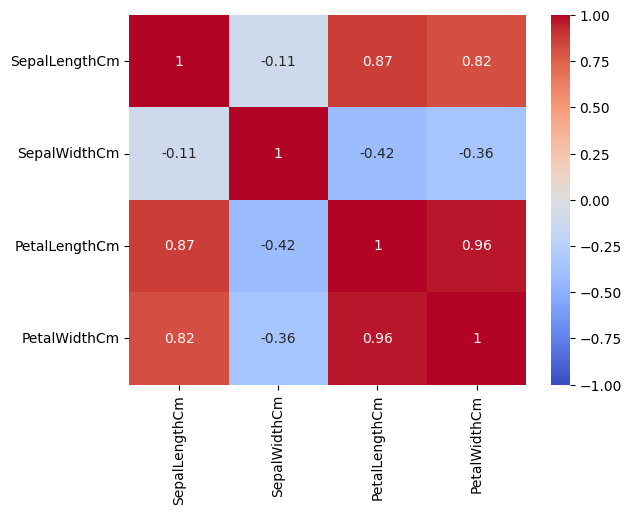

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(corr_matrix_df,annot=True,vmin=-1,vmax=1,cmap='coolwarm')
plt.show()